# Creating animations alongside video for exploring sound-movement couplings
<br>
<div align="center">Wim Pouw (wim.pouw@donders.ru.nl)</div>

<img src="Images/envision_banner.png" alt="isolated" width="300"/>
<img src="Images/7monthinfant.gif" alt="isolated" width="300"/>

## Info documents

This python notebook runs you through the procedure of animating some body and audio timeseries alongside the video. It takes as input some video of a person moving with audio (e.g., vocalizations) and it gives a masked (optional) video with the audio and motion tracking overlayed in one video. Here we took a video from youtube of a 7-month infant who is performing vocalizations together with body movements, also called vocal-motor babbling (see Pouw & Fuchs, 2022; Laudanska et. al., 2022 for theoretical discussions and experimental work on this phenomenon). But you can use any video as input. 

In steps below, we extract the amplitude envelope of the vocalic energy from the audio (following Tilsen & Arviniti, 2013), and then we perform motion tracking with masking using mediapipe and masked piper. Finally, we render a new movie where we integrate the time series with the video, which allows for more qualitative assesment of possible vocal-motor coupling using the newly acquired quantitative tracks.

* location Repository:  https://github.com/WimPouw/envisionBOX_modulesWP/tree/main/AnimatingSoundMovement

* location Jupyter notebook: https://github.com/WimPouw/envisionBOX_modulesWP/tree/main/AnimatingSoundMovement.ipynb

* Current Github: https://github.com/WimPouw/envisionBOX_modulesWP/

### Citations for tools utilized here 

#### Citation of mediapipe
citation: Lugaresi, C., Tang, J., Nash, H., McClanahan, C., Uboweja, E., Hays, M., ... & Grundmann, M. (2019). Mediapipe: A framework for building perception pipelines. arXiv preprint arXiv:1906.08172.

#### Citation of masked piper
* citation: Owoyele, B., Trujillo, J., De Melo, G., & Pouw, W. (2022). Masked-Piper: Masking personal identities in visual recordings while preserving multimodal information. SoftwareX, 20, 101236. 
* Original Repo: https://github.com/WimPouw/TowardsMultimodalOpenScience

#### Citation for making animations
Pouw, W. (2024). Wim Pouw's EnvisionBOX modules for social signal processing (Version 1.0.0) [Computer software]. https://github.com/WimPouw/envisionBOX_modulesWP

#### Youtube video used for this example
I used this video from youtube: [https://www.youtube.com/watch?v=n-tm9XkUNE8](https://www.youtube.com/watch?v=n-tm9XkUNE8).

### Use
Make sure to install all the packages in requirements.txt. Then move your videos that you want to process into the inputfolder. Then run this code, which will loop through all the videos contained in the input folder; and saves all the result animations in the output folders.

Please use, improve and adapt as you see fit.

### References
Tilsen, S., & Arvaniti, A. (2013). Speech rhythm analysis with decomposition of the amplitude envelope: Characterizing rhythmic patterns within and across languages. The Journal of the Acoustical Society of America, 134(1), 628-639.

Pouw, W., & Fuchs, S. (2022). Origins of vocal-entangled gesture. Neuroscience & Biobehavioral Reviews, 141, 104836.

Laudanska, Z., López Pérez, D., Kozioł, A., Radkowska, A., Babis, K., Malinowska-Korczak, A., & Tomalski, P. (2022). Longitudinal changes in infants' rhythmic arm movements during rattle-shaking play with mothers. Frontiers in Psychology, 13, 896319.

# Step 0: setting up the folders
We'll first the folders and videofiles, extract the audio from it, and initalize some packages.

In [1]:
# Step 0: Setting up the folders and files
import mediapipe as mp #mediapipe
import cv2 #opencv
import math #basic operations
import numpy as np #basic operations
import pandas as pd #data wrangling
import csv #csv saving
import os #some basic functions for inspecting folder structure etc.
from os import listdir
from os.path import isfile, join
import glob as glob
import moviepy as mop

#list all videos in input_videofolder
myinputpath = "./inputvideo/" #this is your folder with (all) your video(s)
#list all filenames that has .mp4 or .avi or .mov extensions
vfiles = [f for f in listdir(myinputpath) if isfile(join(myinputpath, f)) and f.endswith(('.mp4', '.avi', '.mov'))]
#time series output folder
inputfol = "./inputvideo/"
outputf = "./outputvideo/"
outtputf_ts = "./outputTS/"

# loop over the videos and extract a wav too with the same filename
for i in vfiles:
    videofilename = inputfol + i
    # Extract audio from the video
    video = mop.VideoFileClip(videofilename)
    audio = video.audio
    # save the audio as mono wav
    audio.write_audiofile(videofilename.replace(".mp4", ".wav"), codec='pcm_s16le', ffmpeg_params=["-ac", "1"])

# list the audiofiles present
audiofiles = [f for f in listdir(myinputpath) if isfile(join(myinputpath, f)) and f.endswith(('.wav'))]

#check videos to be processed
print("The following folder is set as the output folder where all the pose time series are stored")
print(os.path.abspath(outtputf_ts))
print("\n The following folder is set as the output folder for saving the masked videos ")
print(os.path.abspath(outputf))
print("\n The following video(s) will be processed for masking: ")
print(vfiles)
print("\n We have the following audio files: ")
print(audiofiles)

MoviePy - Writing audio in ./inputvideo/03_example.wav


MoviePy - Done.
The following folder is set as the output folder where all the pose time series are stored
c:\Research_Projects\WinterLOTschool_MultimodalComputational\Assignment_AnimatingSoundMovement\outputTS

 The following folder is set as the output folder for saving the masked videos 
c:\Research_Projects\WinterLOTschool_MultimodalComputational\Assignment_AnimatingSoundMovement\outputvideo

 The following video(s) will be processed for masking: 
['03_example.mp4']

 We have the following audio files: 
['03_example.wav']


# Step 1: Extracting amplitude envelope from the audio from video
First we prepare a function to get the amplitude envelope from audio. We follow Arviniti & Tilsen (2013) here, who extract a vocalic energy amplitude envelope using bandpass and low pass filtering. The only difference is that we 

* We do not downsample
* We do not apply Tukey window, as we do not do spectral analyses
* We apply a zero-phase (filtfilt) filters because we dont want to get phase-distortions, which can affect timing measures.

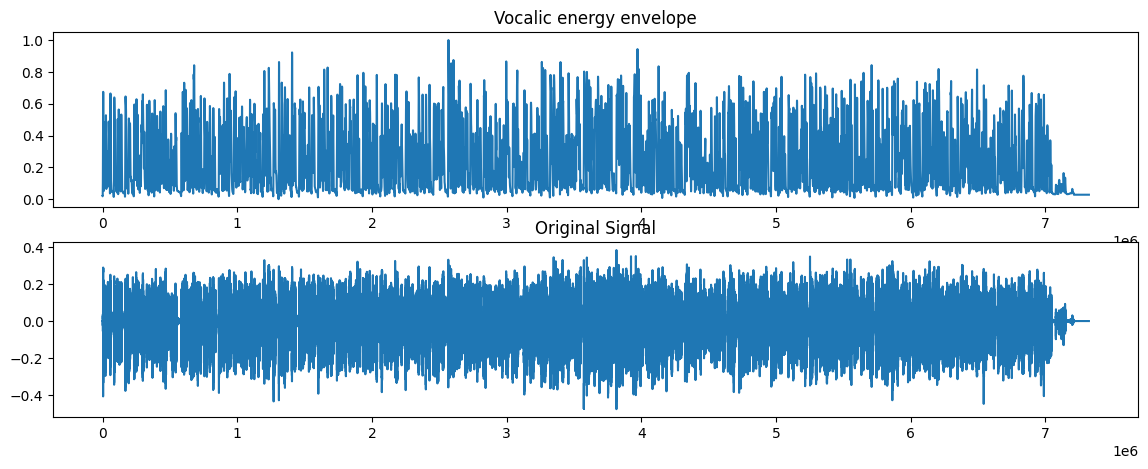

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import librosa
import librosa.display

# Define the bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Define the lowpass filter
def butter_lowpass(cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=2):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Function to extract amplitude envelope
def amp_envelope(audiofilename):
    # load audio with librosa
    audio, sr = librosa.load(audiofilename, sr=None)
    # Bandpass filter 400-4000Hz
    data = butter_bandpass_filtfilt(audio, 400, 4000, sr, order=2)
    # Lowpass filter 10Hz
    data = butter_lowpass_filtfilt(np.abs(data), 10, sr, order=2)
    # scale from 0 to 1
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return data, sr

# Get the amplitude envelope
audiofilename = inputfol+audiofiles[0]
ampv, sr = amp_envelope(audiofilename)
# Plot the filtered signal and the original signal
plt.figure(figsize=(14, 5))
plt.subplot(2, 1, 1)
plt.plot(ampv)
plt.title('Vocalic energy envelope')

# Extract and plot the original signal
rawaudio, sr = librosa.load(audiofilename, sr=None)
plt.subplot(2, 1, 2)
plt.plot(rawaudio)
plt.title('Original Signal')
plt.show()


# Step 2: now apply the masking and tracking of the videos
The code here basically follow the envisionBOX module on masking.

In [3]:
# do you want to apply masking?
masking = False

#load in mediapipe modules
mp_holistic = mp.solutions.holistic
# Import drawing_utils and drawing_styles.
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

##################FUNCTIONS AND OTHER VARIABLES
#landmarks 33x that are used by Mediapipe (Blazepose)
markersbody = ['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER', 'RIGHT_EYE_OUTER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER',
          'LEFT_EAR', 'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT', 'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 
          'RIGHT_ELBOW', 'LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY', 'LEFT_INDEX', 'RIGHT_INDEX',
          'LEFT_THUMB', 'RIGHT_THUMB', 'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE',
          'LEFT_HEEL', 'RIGHT_HEEL', 'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX']

markershands = ['LEFT_WRIST', 'LEFT_THUMB_CMC', 'LEFT_THUMB_MCP', 'LEFT_THUMB_IP', 'LEFT_THUMB_TIP', 'LEFT_INDEX_FINGER_MCP',
              'LEFT_INDEX_FINGER_PIP', 'LEFT_INDEX_FINGER_DIP', 'LEFT_INDEX_FINGER_TIP', 'LEFT_MIDDLE_FINGER_MCP', 
               'LEFT_MIDDLE_FINGER_PIP', 'LEFT_MIDDLE_FINGER_DIP', 'LEFT_MIDDLE_FINGER_TIP', 'LEFT_RING_FINGER_MCP', 
               'LEFT_RING_FINGER_PIP', 'LEFT_RING_FINGER_DIP', 'LEFT_RING_FINGER_TIP', 'LEFT_PINKY_FINGER_MCP', 
               'LEFT_PINKY_FINGER_PIP', 'LEFT_PINKY_FINGER_DIP', 'LEFT_PINKY_FINGER_TIP',
              'RIGHT_WRIST', 'RIGHT_THUMB_CMC', 'RIGHT_THUMB_MCP', 'RIGHT_THUMB_IP', 'RIGHT_THUMB_TIP', 'RIGHT_INDEX_FINGER_MCP',
              'RIGHT_INDEX_FINGER_PIP', 'RIGHT_INDEX_FINGER_DIP', 'RIGHT_INDEX_FINGER_TIP', 'RIGHT_MIDDLE_FINGER_MCP', 
               'RIGHT_MIDDLE_FINGER_PIP', 'RIGHT_MIDDLE_FINGER_DIP', 'RIGHT_MIDDLE_FINGER_TIP', 'RIGHT_RING_FINGER_MCP', 
               'RIGHT_RING_FINGER_PIP', 'RIGHT_RING_FINGER_DIP', 'RIGHT_RING_FINGER_TIP', 'RIGHT_PINKY_FINGER_MCP', 
               'RIGHT_PINKY_FINGER_PIP', 'RIGHT_PINKY_FINGER_DIP', 'RIGHT_PINKY_FINGER_TIP']
facemarks = [str(x) for x in range(478)] #there are 478 points for the face mesh (see google holistic face mesh info for landmarks)

print("Note that we have the following number of pose keypoints for markers body")
print(len(markersbody))

print("\n Note that we have the following number of pose keypoints for markers hands")
print(len(markershands))

print("\n Note that we have the following number of pose keypoints for markers face")
print(len(facemarks ))

#set up the column names and objects for the time series data (add time as the first variable)
markerxyzbody = ['time']
markerxyzhands = ['time']
markerxyzface = ['time']

for mark in markersbody:
    for pos in ['X', 'Y', 'Z', 'visibility']: #for markers of the body you also have a visibility reliability score
        nm = pos + "_" + mark
        markerxyzbody.append(nm)
for mark in markershands:
    for pos in ['X', 'Y', 'Z']:
        nm = pos + "_" + mark
        markerxyzhands.append(nm)
for mark in facemarks:
    for pos in ['X', 'Y', 'Z']:
        nm = pos + "_" + mark
        markerxyzface.append(nm)

#check if there are numbers in a string
def num_there(s):
    return any(i.isdigit() for i in s)

#take some google classification object and convert it into a string
def makegoginto_str(gogobj):
    gogobj = str(gogobj).strip("[]")
    gogobj = gogobj.split("\n")
    return(gogobj[:-1]) #ignore last element as this has nothing

#make the stringifyd position traces into clean numerical values
def listpostions(newsamplemarks):
    newsamplemarks = makegoginto_str(newsamplemarks)
    tracking_p = []
    for value in newsamplemarks:
        if num_there(value):
            stripped = value.split(':', 1)[1]
            stripped = stripped.strip() #remove spaces in the string if present
            tracking_p.append(stripped) #add to this list  
    return(tracking_p)

#We will now loop over all the videos that are present in the video file
for vidf in vfiles:
    print("We will now process video:")
    print(vidf)
    #capture the video, and check video settings
    videoname = vidf
    videoloc = inputfol + videoname
    # replace .mp4 with masked.mp4
    capture = cv2.VideoCapture(videoloc) #load in the videocapture
    frameWidth = capture.get(cv2.CAP_PROP_FRAME_WIDTH) #check frame width
    frameHeight = capture.get(cv2.CAP_PROP_FRAME_HEIGHT) #check frame height
    samplerate = capture.get(cv2.CAP_PROP_FPS)   #fps = frames per second

    #make an 'empty' video file where we project the pose tracking on
    fourcc = cv2.VideoWriter_fourcc(*'MP4V') #for different video formats you could use e.g., *'XVID'
    videonameout = videoname.replace(".mp4", "_masked.mp4")
    out = cv2.VideoWriter(outputf+videonameout, fourcc, 
                          fps = samplerate, frameSize = (int(frameWidth/2), int(frameHeight/2))) # lets downsize the video to half the pixels

    # Run MediaPipe frame by frame using Holistic with `enable_segmentation=True` to get pose segmentation.
    time = 0
    tsbody = [markerxyzbody]   #these will be your time series objects, which start with collumn names initialized above
    tshands = [markerxyzhands] #these will be your time series objects, which start with collumn names initialized above
    tsface = [markerxyzface]   #these will be your time series objects, which start with collumn names initialized above
    with mp_holistic.Holistic(
            static_image_mode=False, enable_segmentation=True, refine_face_landmarks=True) as holistic:
        while (True):
            ret, image = capture.read() #read frame
            if ret == True: #if there is a frame
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #make sure the image is in RGB format
                results = holistic.process(image) #apply Mediapipe holistic processing
                # Draw pose segmentation
                h, w, c = image.shape
                if  np.all(results.face_landmarks) != None: #check if there is a pose found
                    if masking == False:
                        original_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    if masking == True:
                        original_image = np.concatenate([image, np.full((h, w, 1), 255, dtype=np.uint8)], axis=-1)
                        mask_img = np.zeros_like(image, dtype=np.uint8) #set up basic mask image
                        mask_img[:, :] = (255,255,255) #set up basic mask image
                        segm_2class = 0.2 + 0.8 * results.segmentation_mask #set up a segmentation of the results of mediapipe
                        segm_2class = np.repeat(segm_2class[..., np.newaxis], 3, axis=2) #set up a segmentation of the results of mediapipe
                        annotated_image = mask_img * segm_2class * (1 - segm_2class) #take the basic mask image and make a sillhouette mask
                        # append Alpha channel to sillhouetted mask so that we can overlay it to the original image
                        mask = np.concatenate([annotated_image, np.full((h, w, 1), 255, dtype=np.uint8)], axis=-1)
                        # Zero background where we want to overlay
                        original_image[mask==0]=0 #for the original image we are going to set everything at zero for places where the mask has to go
                        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)
                    #now lets draw on the original_image the left and right hand landmarks, the facemesh and the body poses
                        #left hand
                    mp_drawing.draw_landmarks(original_image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
                        #right hand
                    mp_drawing.draw_landmarks(original_image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
                        #face
                    mp_drawing.draw_landmarks(
                            original_image,
                            results.face_landmarks,
                            mp_holistic.FACEMESH_TESSELATION,
                            landmark_drawing_spec=None,
                            connection_drawing_spec=mp_drawing_styles
                            .get_default_face_mesh_tesselation_style())
                        #body
                    mp_drawing.draw_landmarks(
                            original_image,
                            results.pose_landmarks,
                            mp_holistic.POSE_CONNECTIONS,
                            landmark_drawing_spec=mp_drawing_styles.
                            get_default_pose_landmarks_style())
                    #######################now save everything to a time series
                        #make a variable list with x, y, z, info where data is appended to
                    samplebody = listpostions(results.pose_landmarks)
                    samplehands = listpostions([results.left_hand_landmarks, results.right_hand_landmarks])
                    sampleface = listpostions(results.face_landmarks)
                    samplebody.insert(0, time)
                    samplehands.insert(0, time)
                    sampleface.insert(0, time)
                    tsbody.append(samplebody)   #append to the timeseries object
                    tshands.append(samplehands) #append to the timeseries object
                    tsface.append(sampleface)   #append to the timeseries object
                #show the video as we process
                if np.all(results.face_landmarks) == None:
                    original_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    # add empy row of DATA NA
                    samplebody = [np.nan for x in range(len(markerxyzbody)-1)]
                    samplehands = [np.nan for x in range(len(markerxyzhands)-1)]
                    sampleface = [np.nan for x in range(len(markerxyzface)-1)]
                    samplebody.insert(0, time)
                    samplehands.insert(0, time)
                    sampleface.insert(0, time)
                    tsbody.append(samplebody)   #append to the timeseries object
                    tshands.append(samplehands) #append to the timeseries object
                    tsface.append(sampleface)   #append to the timeseries object
                #show the video as we process (you can comment this out, if you want to run this process in the background)
                cv2.imshow("resizedimage", original_image)
                # downsize the video to half the pixels
                original_image = cv2.resize(original_image, (int(frameWidth/2), int(frameHeight/2)))
                out.write(original_image) #save the frame to the new masked video
                time = time+(1000/samplerate)#update the time variable  for the next frame
            if cv2.waitKey(1) == 27: #allow the use of ESCAPE to break the loop
                   break
            if ret == False: #if there are no more frames, break the loop
                break

    #once done uninitialize all processes
    out.release()
    capture.release()
    cv2.destroyAllWindows()
     ####################################################### data to be written row-wise in csv fil
    # opening the csv file in 'w+' mode
    filebody = open(outtputf_ts + vidf[:-4]+'_body.csv', 'w+', newline ='')
    #write it
    with filebody:    
        write = csv.writer(filebody)
        write.writerows(tsbody)
     # opening the csv file in 'w+' mode
    filehands = open(outtputf_ts + vidf[:-4]+'_hands.csv', 'w+', newline ='')
    #write it
    with filehands:
        write = csv.writer(filehands)
        write.writerows(tshands)
    # opening the csv file in 'w+' mode
    fileface = open(outtputf_ts + vidf[:-4]+'_face.csv', 'w+', newline ='')
    #write it
    with fileface:    
        write = csv.writer(fileface)
        write.writerows(tsface)

print("Done with processing all folders; go look in your output folders!")    

Note that we have the following number of pose keypoints for markers body
33

 Note that we have the following number of pose keypoints for markers hands
42

 Note that we have the following number of pose keypoints for markers face
478
We will now process video:
03_example.mp4
Done with processing all folders; go look in your output folders!


# Step 3: Animating a video
Now we are arriving at the fun part. We have our motion tracking performed and saved as a video (and time series), and our amplitude envelope function ready as well. Now we simply need to loop over the motion tracking video frames, and generate a plot that shows the movement speed and the envelope data for that moment, plus some time before and after. We set the time window for 4 seconds, where we show -2 and plus 2 seconds relative to the current moment in the video.

Note that this does take some time rendering. This is because you need to create a plot for every frame, and write a video with the plot now added to the masked video. 

./outputvideo/03_example_masked.mp4


  0%|          | 0/4149 [00:00<?, ?it/s]C:\Users\u668173\AppData\Local\Temp\ipykernel_38756\3290301296.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  body['time'] = body['time'] - midpoint
C:\Users\u668173\AppData\Local\Temp\ipykernel_38756\3290301296.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  audio['time'] = audio['time'] - midpoint
  1%|▏         | 55/4149 [00:33<41:42,  1.64it/s]


KeyboardInterrupt: 

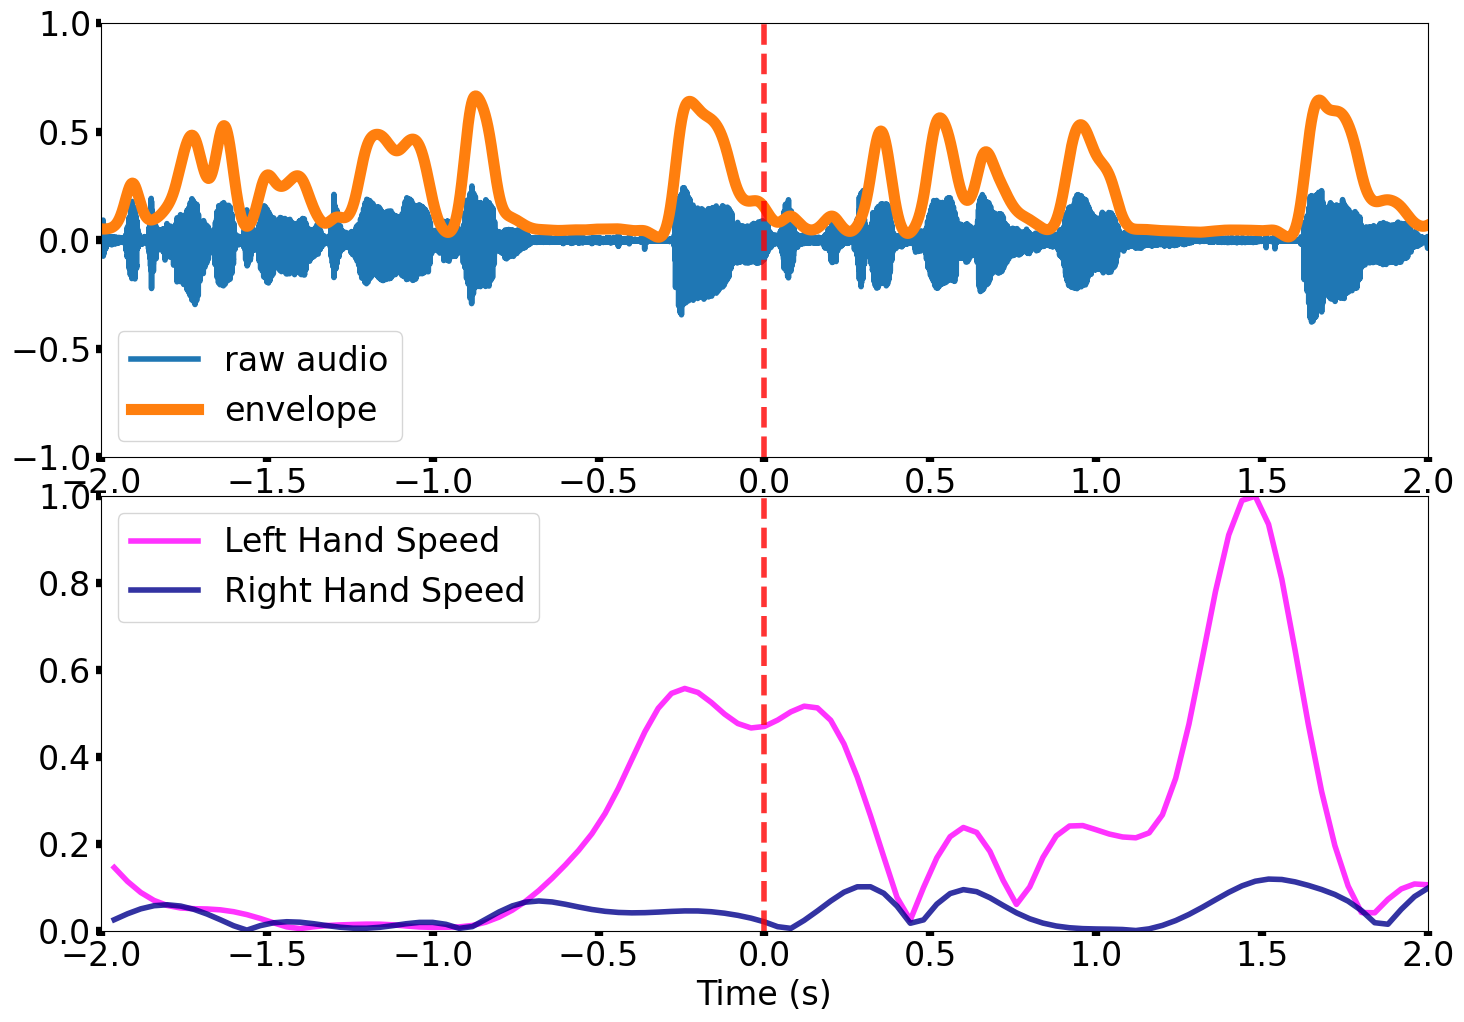

In [4]:
import tempfile
import shutil
import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
# guassian filter
from scipy.ndimage import gaussian_filter

# what is the window size in seconds
window = 4

# a function that generates a plot containing two panel time series of the envelope (panel 1) and the pose time series (panel 2) with a window of 4 seconds
def plot_envelope_pose(body, audio, midpoint):
    # make a temporary folder
    tempfolder = tempfile.mkdtemp()
    fig, ax = plt.subplots(2, 1, figsize=(14, 10))
    # selection 4 seconds from midpoint
    start = midpoint - window/2
    end = midpoint + window/2
    # if start is negative, set it to 0
    if start < 0:
        start = 0
    # subset the body time series and amplitude envelope based on the start and end
    body = body[(body['time'] >= start) & (body['time'] <= end)]
    audio = audio[(audio['time'] >= start) & (audio['time'] <= end)]
    # do a cross correlation between the envelope and the pose time series
    # recenter time
    body['time'] = body['time'] - midpoint
    audio['time'] = audio['time'] - midpoint
    # Plot the amplitude envelope
    ax[0].plot(audio['time'], audio['audio'], label= 'raw audio', linewidth=4)
    ax[0].plot(audio['time'], audio['envelope'], label = 'envelope', linewidth=8)
    ax[0].legend() # show labels in legend
    ax[0].legend(prop={'size': 24})
    # Plot the pose time series with a thick line semitransparent, but different colors (black & grey)
    ax[1].plot(body['time'], body['left_wrist_speed'], label='Left Hand Speed', color='magenta', alpha=0.8, linewidth=4)
    ax[1].plot(body['time'], body['right_wrist_speed'], label='Right Hand Speed', color='darkblue', alpha=0.8, linewidth=4)
    ax[1].set_xlabel('Time (s)', fontsize=24)
    ax[1].legend() # show labels in legend
    ax[1].legend(prop={'size': 24})
    plt.tight_layout()
    # set the x axes to centered by 0 minus and plus half the window
    ax[0].set_xlim(-window/2, window/2)
    ax[1].set_xlim(-window/2, window/2)
    # add a vertical line in the plot at 0
    ax[0].axvline(x=0, color='r', linestyle='--', linewidth=4, alpha=0.8)
    ax[1].axvline(x=0, color='r', linestyle='--', linewidth=4, alpha=0.8)
    # set the y axes 
    ax[0].set_ylim(-1, 1)
    ax[1].set_ylim(0, 1)
    # increase font size
    for a in ax:
        a.tick_params(axis='both', which='major', labelsize=24)
        a.tick_params(axis='both', which='major', width=6)
    # save the plot
    tpf = tempfolder + 'tempfig.png'
    plt.savefig(tpf )
    plt.close()
    img = cv2.imread(tpf)
    shutil.rmtree(tempfolder)
    return img

# we loop over the video files and generate animated videos (with and without sound)
for vidf in vfiles:
    videofilename = outputf + vidf
    audiofilename = inputfol + vidf.replace(".mp4", ".wav")
    videofilenamemasked = videofilename.replace(".mp4", "_masked.mp4")
    print(videofilenamemasked)
    # Get the amplitude envelope
    ampv, sr = amp_envelope(audiofilename)
    # get the raw audio
    rawaudio, sr = librosa.load(audiofilename, sr=None)
    # save the audio and envelope in a pandas with time in seconds
    audio = pd.DataFrame({'time': np.arange(0, len(rawaudio)/sr, 1/sr), 'audio': rawaudio, 'envelope': ampv})
    # Load the pose time series
    body = pd.read_csv(outtputf_ts + vidf[:-4] + '_body.csv')
    # now calculate the right hand and left hand speed
    body['time'] = body['time']/1000
    # interpolate nan using lambda, first set nan to NaN
    body = body.replace('nan', np.nan)
    #  # approx nas using lambda
    body = body.apply(lambda x: x.interpolate(method='linear') if x.name != 'time' else x)
    # smooth all the time series using lambda using guassian
    body = body.apply(lambda x: gaussian_filter(x, 3) if x.name != 'time' else x)
    # calculate the speed of the left and right hand
    body['left_wrist_speed'] = np.insert(np.sqrt(np.diff(body['X_LEFT_WRIST'])**2 + np.diff(body['Y_LEFT_WRIST'])**2),0,0)
    body['right_wrist_speed'] = np.insert(np.sqrt(np.diff(body['X_RIGHT_WRIST'].diff())**2 + np.diff(body['Y_RIGHT_WRIST'])**2),0,0)
     # Normalize the speed to 0-1 by the min/max right hand speed 
    body['left_wrist_speed'] = (body['left_wrist_speed'] - np.min(body['left_wrist_speed'])) / (np.max(body['left_wrist_speed']) - np.min(body['left_wrist_speed']))
    body['right_wrist_speed'] = (body['right_wrist_speed'] - np.min(body['right_wrist_speed'])) / (np.max(body['right_wrist_speed']) - np.min(body['right_wrist_speed']))
    # load the video in opencv and prepare to loop over it
    capture = cv2.VideoCapture(videofilenamemasked)
    frameWidth = capture.get(cv2.CAP_PROP_FRAME_WIDTH)
    frameHeight = capture.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fps = capture.get(cv2.CAP_PROP_FPS)
    # out
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(videofilenamemasked[:-4] + '_animated.mp4', fourcc, fps, (int(frameWidth), int(frameHeight)*2))
    # loop over the video
     # loop through the video and add the plot to the video on left upper corner in small inset
    frame_number = 0
    # with progress bar
    for i in tqdm.tqdm(range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT)))):
        ret, frame = capture.read()
        if ret == True:
            img = plot_envelope_pose(body, audio, frame_number/fps)
            # resize the image
            img = cv2.resize(img, (int(frameWidth), int(frameHeight)))
            # lets put the plot on the under side (axis = 0) of the frame using concat
            frame = np.concatenate([frame, img], axis=0)            
            out.write(frame)
            frame_number += 1
            # also show the frame (optional)
            #cv2.imshow('Frame', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break
    capture.release()
    out.release()    
    cv2.destroyAllWindows()


# Final Result
Below the new animated video is shown. Note that you can adapt a lot of things in the above code. You can for example adjust the window size. Or you want to use different keypoints (just change the body keypoints), or you want to show the values in meters p/s (then adjust mediapipe to world coordinates, and undo the normalization). I believe that visualizing data like this can help communicate otherwise abstract and aggregated research findings because you can now point back to important moments in the actual real-time data while also showing the measures that you are extracting from it.

In [ ]:
# add the audio
# load in the video again and add the audio using moviepy
for vidf in vfiles:
    videofilename = outputf + vidf[:-4] + '_masked_animated.mp4'
    audiofilename = inputfol + vidf.replace(".mp4", ".wav")
    video = mop.VideoFileClip(videofilename)
    audio = mop.AudioFileClip(audiofilename)
    video = video.set_audio(audio)
    video.write_videofile(outputf + vidf[:-4] + '_animated_audio.mp4', codec='libx264', audio_codec='aac')
    video.close()

# show the video in the notebook
from IPython.display import Video
Video(outputf + vfiles[0][:-4] + '_animated_audio.mp4', width=800, embed = True)

d:\Programs\Conda_packages\envs\envision\lib\site-packages\moviepy\video\io\ffmpeg_reader.py:157: UserWarning: In file ./outputvideo/03_example_masked_animated.mp4, 3 bytes wanted but 0 bytes read at frame index 0 (out of a total 0 frames), at time 0.00/0.00 sec. Using the last valid frame instead.
  warnings.warn(


OSError: MoviePy error: failed to read the first frame of video file ./outputvideo/03_example_masked_animated.mp4. That might mean that the file is corrupted. That may also mean that you are using a deprecated version of FFMPEG. On Ubuntu/Debian for instance the version in the repos is deprecated. Please update to a recent version from the website.